In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Data Preprocessing

In [27]:
df= pd.read_csv('data.csv')
df.head()

,date,temperature,humidity,wind_speed,outlook
0,2021-01-01,26.03,52.33,11.62,sunny
1,2021-01-02,26.39,55.79,7.32,sunny
2,2021-01-03,26.93,60.79,6.38,sunny
3,2021-01-04,27.93,64.21,6.69,sunny
4,2021-01-05,28.28,66.04,7.42,rainy


### Kiểm tra missing data

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1045 non-null   object 
 1   temperature  1045 non-null   float64
 2   humidity     1045 non-null   float64
 3   wind_speed   1045 non-null   float64
 4   outlook      1045 non-null   object 
dtypes: float64(3), object(2)
memory usage: 40.9+ KB


### Kiểm tra dữ liệu có phân phối gaussian hay không

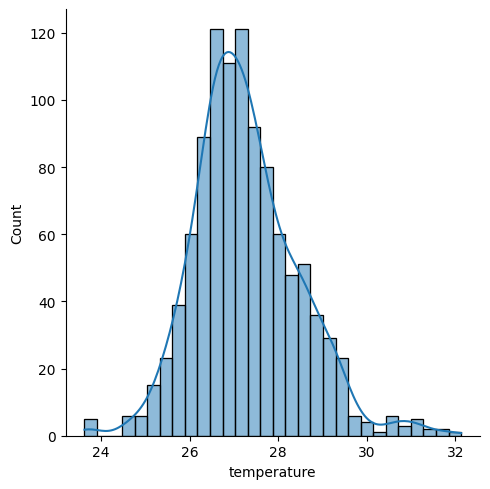

In [29]:
sns.displot(df['temperature'],kde=True,bins=30)

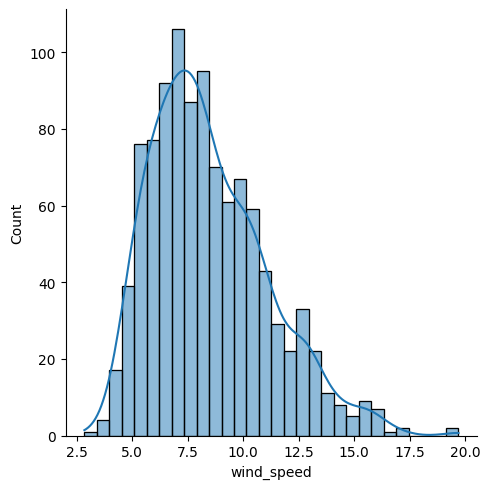

In [30]:
sns.displot(df['wind_speed'],kde=True,bins=30)

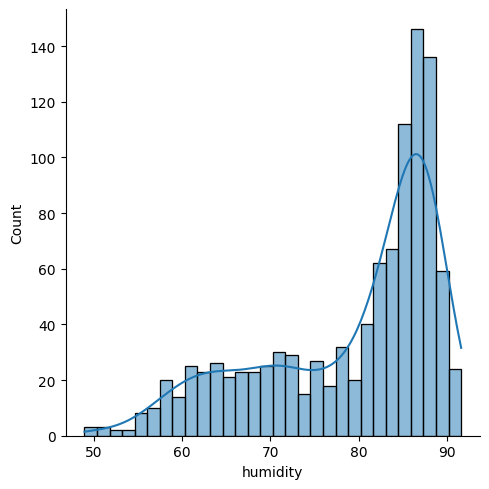

In [31]:
sns.displot(df['humidity'],kde=True,bins=30)

### Dựa vào histplot ta thấy cột dữ liệu wind_speed và humidity không có dạng phân phối chuẩn

***Xử lý cột dữ liệu  wind_speed để có dạng phân phối gaussian bằng cách chuyển đổi dữ liệu bằng pp  Log Transformation*** 

In [32]:
df['wind_speed']=np.round(np.log(df['wind_speed']),2)

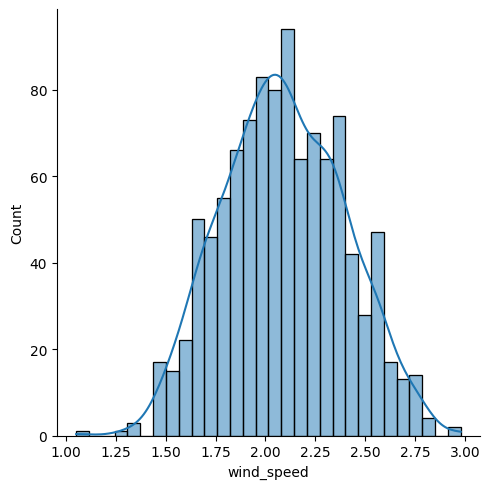

In [33]:
sns.displot(df['wind_speed'],kde=True,bins=30)

***Xử lý cột dữ liệu  humidity bằng cách dán nhãn dữ liệu vì cột dữ liệu humidity không thể chuyển đổi thành dữ liệu có phân phối gaussian (đồ thị ban đầu không có hình chuông)***

In [34]:
df['humidity']=np.where(df['humidity']>df['humidity'].mean(),'High','Normal')

***Dữ Liệu Khi Đã Xử Lý Để Phù Hợp Với Mô Hình Gaussian Naive Bayes***

In [35]:
df

,date,temperature,humidity,wind_speed,outlook
0,2021-01-01,26.03,Normal,2.45,sunny
1,2021-01-02,26.39,Normal,1.99,sunny
2,2021-01-03,26.93,Normal,1.85,sunny
3,2021-01-04,27.93,Normal,1.90,sunny
4,2021-01-05,28.28,Normal,2.00,rainy
...,...,...,...,...,...
1040,2023-11-07,26.94,High,1.83,rainy
1041,2023-11-08,27.36,High,1.84,sunny
1042,2023-11-09,27.50,High,2.02,rainy
1043,2023-11-10,26.38,High,1.79,sunny


***Chia Dữ Liệu Cho Mô Hình***

In [36]:
X=df.iloc[:,1:-1]
y=df.iloc[:,-1]

In [37]:
def train_test_split (X, Y, test_size_ratio, _random_state = None):
    #Merge into a single dataframe
    data = pd.concat([X, Y], axis=1)
    
    # Shuffle the data randomly
    data = data.sample(frac=1, random_state = _random_state)

    # Calculate the index to split the data
    split_index = int(len(data) * (1 - test_size_ratio))

    # Split the data into training and testing sets
    train_data = data[:split_index]
    test_data = data[split_index:]

    # Separate X and y for training and testing sets
    X_train = train_data.iloc[:, :-1]
    Y_train = train_data.iloc[:, -1]
    X_test = test_data.iloc[:, :-1]
    Y_test = test_data.iloc[:, -1]

    return X_train, X_test, Y_train, Y_test


In [38]:
X_train, X_test, y_train, y_test=train_test_split(X,y,0.07,5)

# Xây Dụng Mô Hình Gaussian Naive Bayes

In [39]:
class NaiveBayes:
    def __init__(self):
        self.class_stats={}
    def Fit(self,X,y):
        # Calculate Mean
        def Mean(X:np.ndarray)->float:
            result=0
            for i in range(len(X)):
                result += X[i]
            return result/len(X)
        # Calculate Standard Deviation
        def Std(X:np.ndarray)->float:
            mean=Mean(X)
            result=0
            for i in range(len(X)):
                result += (X[i]-mean)**2
            return np.sqrt(result/(len(X)-1))
        # Fill probability_Or_statistics_of_feature with Prior, Mean and Standard Deviation
        classes_y,classes_y_counts = np.unique(y.values,return_counts=True)
        for class_y,class_count in zip(classes_y,classes_y_counts):
            self.class_stats[class_y] = {'Prior':round(class_count/y.shape[0],2)}
            for feature in X.columns:
                if(X[feature].dtype=='object'):
                    self.class_stats[class_y][feature]={}
                    for class_ in np.unique(X[feature].values):
                        self.class_stats[class_y][feature][class_] = round(X[feature][(X[feature]==class_)&(y==class_y)].shape[0]/class_count,2)
                else:
                    self.class_stats[class_y][feature] = {'Mean':round(Mean(X[feature][y==class_y].values),2)}
                    self.class_stats[class_y][feature]['Standard Deviation'] = round(Std(X[feature][y==class_y].values),2)
    def Predict(self,X):
        # Calculate Gaussian Probability Density Function
        def Gaussian(x,mean,std):
            return (1/(np.sqrt(2*np.pi)*std))*np.exp(-((x-mean)**2)/(2*(std**2)))
        results=[]
        for index in range(X.shape[0]):
            probability_of_rainy=1
            probability_of_sunny=1
            for feature in X.columns:
                if(X[feature].dtype!='object'):
                    mean_sunny=self.class_stats['sunny'][feature]['Mean']
                    mean_rainy=self.class_stats['rainy'][feature]['Mean']
                    std_sunny=self.class_stats['sunny'][feature]['Standard Deviation']
                    std_rainy=self.class_stats['rainy'][feature]['Standard Deviation']
                    probability_of_sunny*=Gaussian(X.iloc[index][feature],mean_sunny,std_sunny)
                    probability_of_rainy*=Gaussian(X.iloc[index][feature],mean_rainy,std_rainy)
                else:
                    value = X.iloc[index][feature]
                    probability_of_sunny *= self.class_stats['sunny'][feature][value]
                    probability_of_rainy *= self.class_stats['rainy'][feature][value]
            probability_of_sunny*=self.class_stats['sunny']['Prior']
            probability_of_rainy*=self.class_stats['rainy']['Prior']
            if(round(probability_of_sunny,2)>round(probability_of_rainy,2)):results.append('sunny')
            else:results.append('rainy')
        return pd.Series(results)
    def Accuracy(self,y_test,y_pred):
        return np.sum(y_test.values==y_pred.values)/len(y_test.values)

# Kiểm Tra Mô Hình

***Kiểm Tra Mô Hình Có Xảy Ra Lỗi Gì Hay Không***

In [40]:
NaiveBayes_for_weather=NaiveBayes()
NaiveBayes_for_weather.Fit(X_train,y_train)
NaiveBayes_for_weather.class_stats

{'rainy': {'Prior': 0.51,
  'temperature': {'Mean': 26.86, 'Standard Deviation': 0.83},
  'humidity': {'High': 0.96, 'Normal': 0.04},
  'wind_speed': {'Mean': 2.03, 'Standard Deviation': 0.31}},
 'sunny': {'Prior': 0.49,
  'temperature': {'Mean': 27.7, 'Standard Deviation': 1.34},
  'humidity': {'High': 0.3, 'Normal': 0.7},
  'wind_speed': {'Mean': 2.14, 'Standard Deviation': 0.29}}}

In [41]:
y_pred=NaiveBayes_for_weather.Predict(X_test)
y_pred

0     rainy
1     rainy
2     sunny
3     sunny
4     sunny
      ...  
69    rainy
70    sunny
71    rainy
72    rainy
73    sunny
Length: 74, dtype: object

***Kiểm tra độ chính xác của mô hình***

In [42]:
NaiveBayes_for_weather.Accuracy(y_test,y_pred)

0.8108108108108109

***Kiểm tra độ chính xác trung bình của mô hình trong 1000 test***

In [43]:
AVG=0
for i in range(1000):
    X_tr, X_t, y_tr, y_t=train_test_split(X,y,0.07,i)
    NaiveBayes_for_weather=NaiveBayes()
    NaiveBayes_for_weather.Fit(X_tr,y_tr)
    y_prd=NaiveBayes_for_weather.Predict(X_t)
    AVG+=NaiveBayes_for_weather.Accuracy(y_t,y_prd)
AVG/1000

0.8160540540540552